# New section

# Tactical ETF Strategy Backtest

This Google Colab notebook implements a rules-based tactical trading strategy using weekly signals on **VTI**, combining EMA crossovers with the Elder Impulse System. It simulates portfolio allocation across ETFs and benchmarks against the S&P 500.

**Key Features:**
- Full indicator warm-up by downloading daily data from 2017
- Weekly resampling and signal generation from 2018–2025 YTD
- Configurable parameters via a dataclass
- Optional Elder Impulse filter toggle
- Portfolio rebalancing logic for Long/Short/Cash states
- Performance metrics: Total Return, CAGR, Max Drawdown, Sharpe, Sortino, Calmar
- Static Matplotlib and interactive Plotly visualizations
- Exports: `equity_curve.csv`, `trade_log.csv`, `performance_metrics.csv`

---

## 1. Install and Import Dependencies


In [1]:
!pip install --quiet yfinance pandas plotly matplotlib



In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import plotly.graph_objects as go

## 2. Configuration

Use a dataclass to centralize strategy parameters and symbols.

In [3]:
@dataclass
class BacktestConfig:
    # Data range for warm-up and backtest
    warmup_start: str = '2017-01-01'
    backtest_start: str = '2018-01-01'
    end_date: str = '2025-04-25'

    # Elder Impulse flag
    strict_elder: bool = True

    # Symbols
    signal: str = 'VTI'
    leveraged_long: str = 'SPXL'
    benchmark: str = '^SPX'
    leveraged_short: str = 'SPXS'
    short_1: str = 'GLDM'
    short_2: str = 'SPTS'
    cash: str = 'BIL'

In [4]:
# Instantiate configuration
config = BacktestConfig()

## 3. Data Download

Download daily price history from Yahoo Finance and resample to weekly frequency (Friday closes).

In [5]:
def download_daily_close(symbols: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Download daily adjusted close prices for given symbols.
    """
    df = yf.download(symbols, start=start, end=end, interval='1d', auto_adjust=True, progress=False)['Close']
    return df.dropna()

symbols = [config.signal, config.leveraged_long, config.benchmark,
           config.leveraged_short, config.short_1, config.short_2, config.cash]

daily_prices = download_daily_close(symbols, config.warmup_start, config.end_date)
weekly_prices = daily_prices.resample('W-FRI').last()

## 4. Indicator Calculation

Compute EMA13, EMA21, SMA50, MACD histogram manually, primary trend, and Elder Impulse bars.

In [6]:
def compute_indicators(prices: pd.Series) -> pd.DataFrame:
    """
    Calculate indicators on a single-price series for weekly data.
    Returns a DataFrame with price and computed columns.
    """
    df = pd.DataFrame({'close': prices})
    # EMAs and SMA
    df['ema13'] = df['close'].ewm(span=13, adjust=False).mean()
    df['ema21'] = df['close'].ewm(span=21, adjust=False).mean()
    df['sma50'] = df['close'].rolling(window=50).mean()

    # MACD line and histogram
    macd_line = df['close'].ewm(span=12, adjust=False).mean() - df['close'].ewm(span=26, adjust=False).mean()
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    df['macd_hist'] = macd_line - signal_line

    # Primary Trend
    df['primary_trend'] = np.where(df['ema21'] > df['sma50'], 'Bullish', 'Bearish')

    # Elder Impulse
    up = (df['ema13'] > df['ema13'].shift(1)) & (df['macd_hist'] > df['macd_hist'].shift(1))
    down = (df['ema13'] < df['ema13'].shift(1)) & (df['macd_hist'] < df['macd_hist'].shift(1))
    df['impulse'] = 'Neutral'
    df.loc[up, 'impulse'] = 'Green'
    df.loc[down, 'impulse'] = 'Red'

    return df

In [7]:
# Compute indicators for VTI weekly
indicator_df = compute_indicators(weekly_prices[config.signal])


## 5. Signal Generation

Generate weekly signals based on EMA21 crossovers and optional Elder filter.

In [8]:
def generate_signals(ind_df: pd.DataFrame, strict_elder: bool) -> pd.Series:
    """
    Returns a Series of positions: 'Long', 'Short', or 'Cash'.
    """
    positions = ['Cash']
    for i in range(1, len(ind_df)):
        prev = ind_df.iloc[i-1]
        curr = ind_df.iloc[i]
        pos = positions[-1]

        # Entry
        if curr.primary_trend == 'Bullish' and prev.close < prev.ema21 and curr.close > curr.ema21:
            if not strict_elder or curr.impulse == 'Green':
                pos = 'Long'
        elif curr.primary_trend == 'Bearish' and prev.close > prev.ema21 and curr.close < curr.ema21:
            if not strict_elder or curr.impulse == 'Red':
                pos = 'Short'

        # Exit
        if pos == 'Long' and curr.close < curr.ema21:
            pos = 'Cash'
        elif pos == 'Short' and curr.close > curr.ema21:
            pos = 'Cash'

        positions.append(pos)

    return pd.Series(positions, index=ind_df.index)

signals = generate_signals(indicator_df, config.strict_elder)

## 6. Backtest Engine

Simulate portfolio returns and equity curve using weekly signals.

In [9]:
def backtest(signals: pd.Series, prices: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(index=signals.index)
    df['signal'] = signals
    weekly_ret = prices.pct_change().fillna(0)
    df['return'] = 0.0

    for date in df.index:
        sig = df.at[date, 'signal']
        if sig == 'Long':
            df.at[date, 'return'] = (
                0.4 * weekly_ret.at[date, config.leveraged_long] +
                0.6 * weekly_ret.at[date, config.benchmark]
            )
        elif sig == 'Short':
            df.at[date, 'return'] = (
                0.4 * weekly_ret.at[date, config.leveraged_short] +
                0.3 * weekly_ret.at[date, config.short_1] +
                0.3 * weekly_ret.at[date, config.short_2]
            )
        else:
            df.at[date, 'return'] = (
                0.4 * 0 +
                0.6 * weekly_ret.at[date, config.cash]
            )

    df['equity'] = (1 + df['return']).cumprod()
    return df.loc[config.backtest_start:]

portfolio = backtest(signals, weekly_prices)

## 7. Performance Metrics

Compute Total Return, CAGR, Max Drawdown, Sharpe, Sortino, and Calmar ratios.

In [10]:
def performance_metrics(equity: pd.Series) -> dict:
    weekly_ret = equity.pct_change().dropna()
    total_return = equity.iloc[-1] - 1
    years = (equity.index[-1] - equity.index[0]).days / 365.25
    cagr = equity.iloc[-1] ** (1/years) - 1

    cummax = equity.cummax()
    drawdown = equity / cummax - 1
    max_dd = drawdown.min()

    mu = weekly_ret.mean() * 52
    sigma = weekly_ret.std() * np.sqrt(52)
    sharpe = mu / sigma if sigma else np.nan

    neg = weekly_ret[weekly_ret < 0]
    downside_sigma = neg.std() * np.sqrt(52) if not neg.empty else np.nan
    sortino = mu / downside_sigma if downside_sigma else np.nan

    calmar = cagr / abs(max_dd) if max_dd < 0 else np.nan

    return {
        'Total Return': total_return,
        'CAGR': cagr,
        'Max Drawdown': max_dd,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Calmar Ratio': calmar
    }

metrics = performance_metrics(portfolio['equity'])

## 8. Export Results

In [11]:
portfolio.to_csv('equity_curve.csv')
pd.DataFrame({'signal': signals}).loc[config.backtest_start:].to_csv('trade_log.csv')
pd.DataFrame([metrics]).to_csv('performance_metrics.csv', index=False)


## 9. Visualizations

Plot static and interactive comparisons of strategy vs. SPX benchmark.

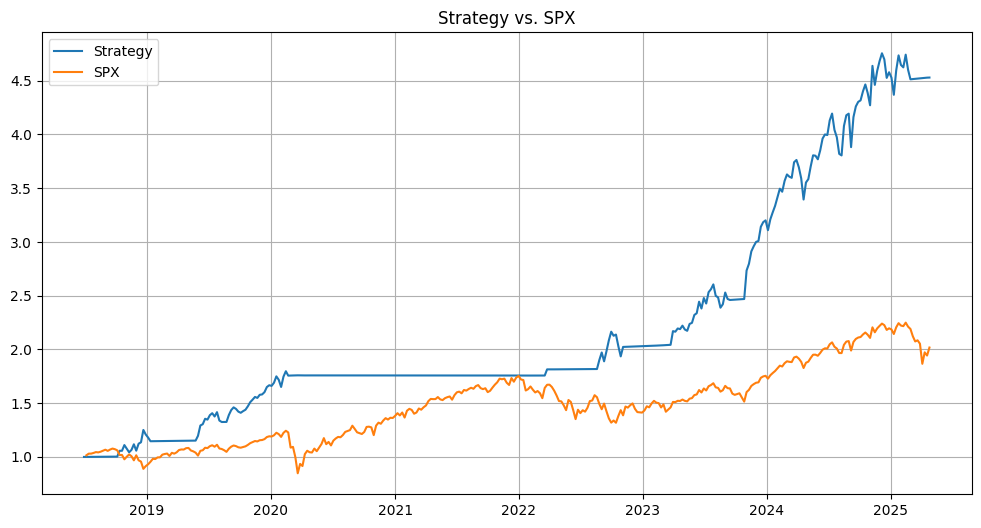

Total Return: 352.95%
CAGR: 0.25
Max Drawdown: -10.61%
Sharpe Ratio: 1.49
Sortino Ratio: 1.90
Calmar Ratio: 2.34


In [12]:
# Prepare benchmark
benchmark = (1 + weekly_prices[config.benchmark].pct_change()).cumprod()
benchmark = benchmark.loc[portfolio.index]

# Static plot
plt.figure(figsize=(12,6))
plt.plot(portfolio['equity'], label='Strategy')
plt.plot(benchmark, label='SPX')
plt.title('Strategy vs. SPX')
plt.legend()
plt.grid(True)
plt.show()

# Interactive plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio.index, y=portfolio['equity'], name='Strategy'))
fig.add_trace(go.Scatter(x=benchmark.index, y=benchmark, name='SPX'))
fig.update_layout(title='Interactive Equity Curve', xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()



## 10. Display Metrics


for name, val in metrics.items():
    label = "%" if 'Return' in name or 'Drawdown' in name else ""
    print(f"{name}: {val:{'.2%' if label=='%' else '.2f'}}")
